In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
import os
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from ipywidgets import fixed, Layout, Button, Box
import scipy.optimize as spopt 

%matplotlib widget
#%matplotlib inline
files = [i for i in os.listdir('.') if '.txt' in i]

run_but = widgets.ToggleButton(
    value=False,
    description='Read File',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

dropdown = widgets.Dropdown(options=files, values=files[0],description='File name',disabled=False)


def get_bound(max_val,min_val):
    if max_val  < 0:
        boundary_max   = -.1 
    else:
        boundary_max   = .1
    if  min_val  < 0:
        boundary_min   = .1
    else:
        boundary_min   = -.1
        return min_val*(1+boundary_min),max_val*(1+boundary_max)

def monoExp(x,a,t):
    return a*np.exp(-x/t)
def trpl_plot(dataframe,bin_num,param_fit1,param_fit2,tot_len,dump_but,legend):
    #print(np.shape(dataframe)[0])
    #plt.clf() 
    plt.figure(5)
    plt.clf()
    fluorescence = dataframe['Time'].to_numpy(float)
    hist, bins = np.histogram(fluorescence, bins=bin_num)
    
    #Plot generator:
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    plt.xlabel("Time (ps)")          #Defines the x axis' label parameters
    plt.ylabel("Intensity (a.u.)")   #Defines the y axis' label parameters
    plt.tick_params(axis='x')        #Customizes the x ticks (axis,size,vertical offset)  
    plt.ylim([-.05,1.05])            #Defines the y range
    plt.tick_params(axis='y')        #Customizes the y ticks (axis,size,horizontal offset)     
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    initial_params=[param_fit1,param_fit2]
    popt, pcov = spopt.curve_fit(monoExp,bins[:-1],hist/max(hist),p0=initial_params)
    fit_curve = [monoExp(x,popt[0],popt[1]) for x in bins[:-1]]
    plt.plot(bins[:-1],hist/max(hist), color='red', label=legend)
    plt.plot(bins[:-1],fit_curve, color='blue', label='Fit')
    avg_lf = np.mean(fluorescence)
    
    print('The fitted lifetime is:', "{:.2f}".format(popt[1]),'ps')
    print('The average lifetime is:', "{:.2f}".format(avg_lf),'ps')
    print('We are using {:.2f} % of the total data'.format(100*len(fluorescence)/tot_len))
    
    legx= plt.legend(bbox_to_anchor=(0.88,0.88), frameon=False ) 
    plt.show()
    
    if dump_but:
        hist_data = np.column_stack([bins[:-1], hist/max(hist)])
        fit_data = np.column_stack([bins[:-1], fit_curve])

        np.savetxt('trpl.txt'     , hist_data, fmt=['%f','%f'])
        np.savetxt('trpl_fit.txt' , fit_data , fmt=['%f','%f'])
    
def get_energy(data):
    return data.Energy
def get_dx(data):
    return data.DeltaX
def get_dy(data):
    return data.DeltaY
def get_dz(data):
    return data.DeltaZ
def get_location(data):
    return data.Location
def filter_data_list(data,keyword,list_choosen):
    return data[(data[keyword].isin(list_choosen))]
def filter_data_range(data,keyword,values):
    dic = {'Energy': get_energy, 'DeltaX': get_dx, 'DeltaY':get_dy, 'DeltaZ': get_dz,'Location':get_location}
    return data[((dic[keyword](data) <= values[1]) & (dic[keyword](data) >= values[0]))] 

def filter_per_particle(dataframe,particle,deaths,mats,energy,status):
    data = filter_data_list(dataframe,'Type',[particle])
    data_filtred = data
    data_filtred = filter_data_list(data_filtred,'CausaMortis',deaths)
    data_filtred = filter_data_range(data_filtred,'Location',mats)
    data_filtred = filter_data_range(data_filtred,'Energy',energy)
    data_filtred = filter_data_list(data_filtred,'Status',status)   
    return data_filtred

def trpl(data,tot_len,particle_existence,**kwargs):
    
    particles_filter = {}
    particles_filter["singlet"] = [kwargs["singl_mats"], kwargs["singl_energy"], 
    kwargs["singl_deaths"], kwargs["singl_status"]]
    
    particles_filter["triplet"] = [kwargs["tripl_mats"], kwargs["tripl_energy"], 
    kwargs["tripl_deaths"], kwargs["tripl_status"]]
    
    particles_filter["hole"]    = [kwargs["hole_mats"], kwargs["hole_energy"], 
    kwargs["hole_deaths"], kwargs["hole_status"]]
    
    particles_filter["electron"] = [kwargs["elect_mats"], kwargs["elect_energy"], 
    kwargs["elect_deaths"], kwargs["elect_status"]]
    
    #for particle in particles_filter:
    #    print(particle,particles_filter[particle])
    #    print()
    data_filtred = []
    for particle in particles_filter:
        if particle_existence[particle][0] != 0:
            #print(particle,particle_existence[particle][0])
            #print(mats,energy,particle,deaths,status,tot_len,particle_existence[particle][0])
            mats,energy,deaths,status = particles_filter[particle]
            data_filtred.append(filter_per_particle(data,particle,deaths,mats,energy,status))
    data_filtred =  pd.concat(data_filtred)
    #print()
    #print()
    #print(data_filtred)
    try:
        bin_slider = widgets.IntSlider(
        value=100,
        max=300,
        min=2,
        step=1,
        description='Number of Bins:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
        )
        param_1 = widgets.BoundedFloatText(
            value=1,
            min=0,
            max=1E+9,
            #step=0.1,
            description='Amplitude:',
            disabled=False
        )

        param_2 = widgets.BoundedFloatText(
            value=3000,
            min=0,
            max=1E+9,
            #step=0.1,
            description='Tau:',
            disabled=False
        )

        dump_but = widgets.ToggleButton(
            value=False,
            description='Export Data',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Description',
            icon='check'
        )

        #display(widgets.HTML(value = r'<p style="font-size:24px"><b>Plot Options</b></p>'))
        #display(widgets.Label('Plot Options', layout=Layout(width='6000px')))
        
        #gettin which processes were selected to the trpl calculation
        legend = []
        legend = legend + list(kwargs["singl_deaths"])  + list(kwargs["tripl_deaths"]) + list(kwargs["elect_deaths"]) + list(kwargs["hole_deaths"])
        legend = [ p for p in legend if p != 'non-present']
        legend = list(set(legend))
        legend = ' '.join(legend)
        
        widgets.interact(trpl_plot,dataframe=fixed(data_filtred),bin_num = bin_slider,param_fit1=param_1,param_fit2=param_2,tot_len=fixed(tot_len),dump_but=dump_but,legend=fixed(legend))
        #i = widgets.interactive(trpl_plot,dataframe=fixed(data_filtred),bin_num = bin_slider,param_fit1=param_1,param_fit2=param_2,tot_len=fixed(tot_len),dump_but=dump_but)
        #func_input   = {"dataframe":fixed(data_filtred), "bin_num":bin_slider, "param_fit1":param_1, "param_fit2":param_2,"tot_len":fixed(tot_len),"dump_but":dump_but}
        #func_calling = widgets.interactive_output(trpl_plot, func_input)
        #v = widgets.VBox([param_1,param_2])
        #h = widgets.HBox([bin_slider,dump_but])
        #h = widgets.HBox([v,h])
        #h = widgets.VBox([h,i])
        #display(h,func_calling)
        
    except:
        print('error')
        pass
    
def get_boxes_for_a_particle(N_boxes,death_list_particle):
    death_list_particle = [x for x in death_list_particle if x != 'non-present']
    n_deaths = len(death_list_particle)
    real_boxes_indx = []
    boxes = []
    for i in range(N_boxes):
        if i+1 <= n_deaths:
            death_name = death_list_particle[i]
            boxes.append(widgets.Checkbox(value=False,description=str(death_name),disabled=False))
        else:
            boxes.append(widgets.Checkbox(value=False,description='---',disabled=True))
    return boxes,death_list_particle


def make_hist_plot(histogram_data):
    try:
        names, counts = zip(*histogram_data)
        print(names, counts)
        x = np.arange(len(names))
        
        plt.figure(3)
        plt.clf()
        plt.bar(x, height=counts)
        plt.xticks(x, names)  
        plt.show()
    except:
        pass
    #x = np.arange(3)
    #plt.bar(x, height=[1,2,3])
    #plt.xticks(x, ['a','b','c']);
def Histogram_func(data,name_deaths,**kwargs):
    
    singlet_boxes = [kwargs["singl_box1"], kwargs["singl_box2"], 
    kwargs["singl_box3"], kwargs["singl_box4"],
    kwargs["singl_box5"], kwargs["singl_box6"]]
    
    histogram_data = []
    for part in name_deaths:
        list_death = name_deaths[part]
        for i in range(len(list_death)):
            death = list_death[i]
            it_is_on = singlet_boxes[i]
            print(death,it_is_on)
            #'''
            if it_is_on:
                data_part = data[part]
                #print(data_part)
                #print(part,death)
                data_filter = filter_data_list(data_part,'CausaMortis',[death])
                n_filter = len(data_filter)
                histogram_data.append([part+'_'+death,n_filter])
            #'''
    #print(histogram_data)
    if histogram_data:
        make_hist_plot(histogram_data)
    #print(singlet_histograms)
    #print(data)
def Histogram_widget(data,tot_len,particle_existence,**kwargs):
    
    #filtering using the common filtering interface
    particles_filter = {}
    particles_filter["singlet"] = [kwargs["singl_mats"], kwargs["singl_energy"], 
    kwargs["singl_deaths"], kwargs["singl_status"]]
    
    particles_filter["triplet"] = [kwargs["tripl_mats"], kwargs["tripl_energy"], 
    kwargs["tripl_deaths"], kwargs["tripl_status"]]
    
    particles_filter["hole"]    = [kwargs["hole_mats"], kwargs["hole_energy"], 
    kwargs["hole_deaths"], kwargs["hole_status"]]
    
    particles_filter["electron"] = [kwargs["elect_mats"], kwargs["elect_energy"], 
    kwargs["elect_deaths"], kwargs["elect_status"]]

    data_filtred = {}
    for particle in particles_filter:
        if particle_existence[particle][0] != 0:
            mats,energy,deaths,status = particles_filter[particle]
            data_filtred[particle] = filter_per_particle(data,particle,deaths,mats,energy,status)  
    
    #getting the death processes relevant for each particle
    death_list = {}
    death_list["singlet"]  = kwargs["singl_deaths"]
    death_list["triplet"]  = kwargs["tripl_deaths"]
    death_list["electron"] = kwargs["elect_deaths"]
    death_list["hole"]     = kwargs["hole_deaths"]
    
    name_deaths = {}
    box_singlet,deaths_singlet = get_boxes_for_a_particle(6,death_list["singlet"])
    
    name_deaths['singlet'] = deaths_singlet
    w_hi = widgets.interactive(Histogram_func,data=fixed(data_filtred),name_deaths=fixed(name_deaths),
                           singl_box1=box_singlet[0],singl_box2=box_singlet[1],
                           singl_box3=box_singlet[2],singl_box4=box_singlet[3],
                           singl_box5=box_singlet[4],singl_box6=box_singlet[5])
    
    
    h = widgets.HBox([w_hi.children[i] for i in range(len(w_hi.children)-1)])
    v = widgets.VBox([widgets.Label('Singlet: '),h,w_hi.children[-1]])
    display(v)
    #display(w_hi)
def get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,unique_status):
    min_bound,max_bound = get_bound(max_energy,min_energy)
    energy = widgets.FloatRangeSlider(
        value=[min_energy, max_energy],
            min=min_bound,
            max=max_bound,
            step=(max_energy-min_energy)/4,
            description='Energy:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )       
    mats = widgets.IntRangeSlider(
            value=[np.amin(unique_mats), np.amax(unique_mats)],
            min=np.amin(unique_mats),
            max=np.amax(unique_mats),
            step=1,
            description='Materials:',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )                
    deaths = widgets.SelectMultiple(
            options=unique_death,
            value=[unique_death[0]],
            #rows=10,
            description='Process',
            disabled=False,
        )
    status = widgets.SelectMultiple(
            options=unique_status,
            value=[unique_status[0]],
            #rows=10,
            description='Status',
            disabled=False,
        )
    return energy,mats,deaths,status

def join_widgets(dataframe,particle):
    
    data = filter_data_list(dataframe,'Type',[particle])
    unique_mats   = data['Location'].unique()
    unique_death  = data['CausaMortis'].unique()
    unique_energy = data['Energy'].unique()
    unique_status = data['Status'].unique()
    max_energy = np.amax(unique_energy)
    min_energy = np.amin(unique_energy)
    energy, mats, deaths,status = get_widgets_per_particle(min_energy,max_energy,
                                                           unique_mats,unique_death,unique_status)
    return [particle,energy, mats, deaths,status]

def make_boxes(deaths,status,mats,energy):
    left_box  = widgets.VBox([deaths,status])
    right_box = widgets.VBox([mats,energy])
    ui = widgets.HBox([left_box,right_box])  
    return ui
def pre_load(file_name,run_button):
    if run_button:
        data = pd.read_csv(file_name, delim_whitespace=True)
        data = data[data.Time != 'END'] #removes the end of round lines
        tot_len = np.shape(data)[0]
        unique_energy = data['Energy'].unique()

        max_energy = np.amax(unique_energy)
        min_energy = np.amin(unique_energy)
        
        ########################################    
        #defining widgets after pre_load process
        #for each particle there is two sets of widgets: 
        # 1) the ones attached to the table : [energy , mats,   deaths, status] 
        # 2) the ones attached to the widget.interactive : [energy2, mats2, deaths2, status2] 
        # Comunication between them is mediated by the report_ie_change function
        types         = {'singlet':0,'triplet':0,'hole':0,'electron':0}
        obserb_dics = {}
        for part in types:
            try:
                data_part = filter_data_list(data,'Type',[part])
                unique_mats   = data_part['Location'].unique()
                unique_death  = data_part['CausaMortis'].unique()
                unique_status = data_part['Status'].unique()
                energy , mats,   deaths, status  = get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,unique_status)
                energy2, mats2, deaths2, status2 = get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,unique_status)

                obserb_dics[part] = ([ mats, energy ,  deaths, status],[mats2, energy2 ,  deaths2, status2])
                ui = make_boxes(deaths,status,mats,energy)
                types[part] = [1,ui]
            except:
                min_energy,max_energy,unique_mats,unique_death,unique_status = 0,1,[0,1],['non-present'],['non-present']
                energy , mats,   deaths, status  = get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,unique_status)
                energy2, mats2, deaths2, status2 = get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,unique_status)
                obserb_dics[part] = ([ mats, energy ,  deaths, status],[mats2, energy2 ,  deaths2, status2])
                types[part] = [0,make_boxes(deaths,status,mats,energy)]
        #xx = [types[part][0] for part in types]
        #print(xx)
        ###########################

        #initializing table
        output = widgets.Output()
        tab_contents = ['SINGLET', 'TRIPLET', 'HOLE', 'ELECTRON']
        children     = [types['singlet'][1], types['triplet'][1], types['hole'][1], types['electron'][1]] #[types[part][1] for part in types] #[w_singlet]#,w_triplet,w_hole,w_electron]
        tab          = widgets.Tab()
        tab.children = children
        #setting up the titles of the table
        for i in range(len(children)):
            tab.set_title(i,tab_contents[i])
        display(tab,output)
        
        
        singl_mats, singl_energy ,  singl_deaths, singl_status = obserb_dics['singlet'][1]
        tripl_mats, tripl_energy ,  tripl_deaths, tripl_status = obserb_dics['triplet'][1]
        hole_mats , hole_energy  ,  hole_deaths , hole_status  = obserb_dics['hole'][1]
        elect_mats, elect_energy ,  elect_deaths, elect_status = obserb_dics['electron'][1]
        
        #Calling Histogram INTERACTIVE INTERFACE
        w_hist = widgets.interactive(Histogram_widget,data=fixed(data),tot_len=fixed(tot_len),particle_existence=fixed(types),
                                singl_mats=singl_mats, singl_energy=singl_energy,
                                singl_deaths=singl_deaths, singl_status=singl_status,
                                tripl_mats=tripl_mats, tripl_energy=tripl_energy,
                                tripl_deaths=tripl_deaths, tripl_status=tripl_status,
                                hole_mats=hole_mats, hole_energy=hole_energy,
                                hole_deaths=hole_deaths, hole_status=hole_status,
                                elect_mats=elect_mats, elect_energy=elect_energy,
                                elect_deaths=elect_deaths, elect_status=elect_status)
        
        #Calling TRPL INTERACTIVE INTERFACE
        w = widgets.interactive(trpl,data=fixed(data),tot_len=fixed(tot_len),particle_existence=fixed(types),
                                singl_mats=singl_mats, singl_energy=singl_energy,
                                singl_deaths=singl_deaths, singl_status=singl_status,
                                tripl_mats=tripl_mats, tripl_energy=tripl_energy,
                                tripl_deaths=tripl_deaths, tripl_status=tripl_status,
                                hole_mats=hole_mats, hole_energy=hole_energy,
                                hole_deaths=hole_deaths, hole_status=hole_status,
                                elect_mats=elect_mats, elect_energy=elect_energy,
                                elect_deaths=elect_deaths, elect_status=elect_status)
        
        accordion = widgets.Accordion(children=[w,w_hist], selected_index=None)
        accordion.set_title(0, 'TRPL')
        accordion.set_title(1, 'HISTOGRAM')
        accordion.set_title(2, 'HEATMAP')
        display(accordion)
        #print(len(accordion.children[0].children),accordion.children[0].children)
        
        #this function updates the atribute value upon changes in the widget. Must remain defined inside of pre_load
        def report_ie_change(change,w,accordion,attrib,indx):
            with output:
                accordion.children[0].children[indx].value = attrib.value

        ##############################    
        # Caution! For some reason, cant put that in a loop. It stops to function
        #for j in [0,1,2,3]:
        #    obserb_dics['singlet'][0][j].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['singlet'][0][j],j))    
        obserb_dics['singlet'][0][0].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['singlet'][0][0],0))
        obserb_dics['singlet'][0][1].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['singlet'][0][1],1))
        obserb_dics['singlet'][0][2].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['singlet'][0][2],2))
        obserb_dics['singlet'][0][3].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['singlet'][0][3],3))
        
        
        obserb_dics['triplet'][0][0].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['triplet'][0][0],4))
        obserb_dics['triplet'][0][1].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['triplet'][0][1],5))
        obserb_dics['triplet'][0][2].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['triplet'][0][2],6))
        obserb_dics['triplet'][0][3].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['triplet'][0][3],7))
        
        obserb_dics['hole'][0][0].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['hole'][0][0],8))
        obserb_dics['hole'][0][1].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['hole'][0][1],9))
        obserb_dics['hole'][0][2].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['hole'][0][2],10))
        obserb_dics['hole'][0][3].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['hole'][0][3],11))
        
        obserb_dics['electron'][0][0].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['electron'][0][0],12))
        obserb_dics['electron'][0][1].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['electron'][0][1],13))
        obserb_dics['electron'][0][2].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['electron'][0][2],14))
        obserb_dics['electron'][0][3].observe(lambda change: report_ie_change(change,w,accordion,obserb_dics['electron'][0][3],15))
        #########################
        
        #needed because by default widget.interactive pops up the widges. Tuning them invisible here..
        for indx in range(len(w.children)-1):
            w.children[indx].close()
        #w.children[0].close()
    else:
        pass   
        


HTML(value='<p style="font-size:24px"><b>DASHBOARD KMC</b></p>')

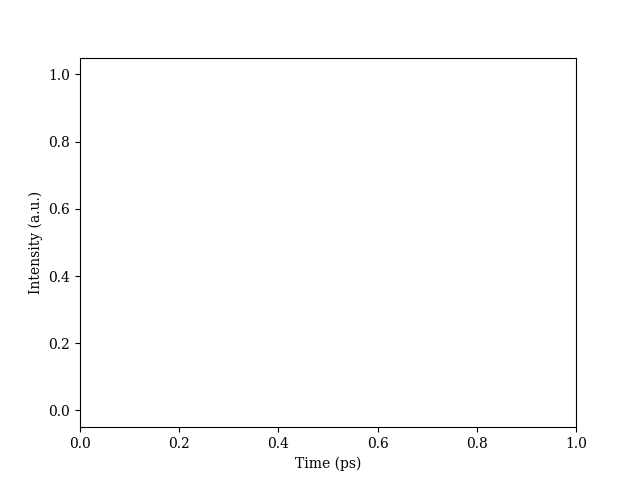

In [26]:
display(widgets.HTML(value = r'<p style="font-size:24px"><b>DASHBOARD KMC</b></p>'))
i = widgets.interactive(pre_load, file_name=dropdown,run_button=run_but);
h = widgets.HBox([i.children[0],i.children[1]])
v = widgets.VBox([h,i.children[2]])
display(v)